In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import your classes
from classes.instruments import Stock, AmericanOption
from classes.position import Position
from classes.portfolio import Portfolio
from classes.pricer import Pricer, AmericanPricer
from classes.OptionStrategy import OptionStrategy, MultiStockStrategy, FactorAnalysis
from classes.utils import get_third_friday

In [2]:
def get_third_friday(year, month):
    """Get the third Friday of a given month and year"""
    date = datetime(year, month, 1)
    days_until_friday = (4 - date.weekday()) % 7
    first_friday = date + timedelta(days=days_until_friday)
    third_friday = first_friday + timedelta(days=14)
    return pd.Timestamp(third_friday)

In [ ]:
def run_straddle(df, stock_ticker, start_date, end_date, atm=True, initial_capital=100000.0, position_sizing=1):
    """
    Run a short straddle strategy
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    atm : bool
        Whether to use at-the-money strikes or slightly OTM
    initial_capital : float
        Initial capital for the strategy
    position_sizing : float
        Multiplier for position size
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Short Straddle"
    
    def straddle_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        if atm:
            # ATM strikes
            call_strike = put_strike = round(price)
        else:
            # Slightly OTM strikes
            call_strike = round(price * 1.05)
            put_strike = round(price * 0.95)
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [(call_option, "Short", 1), (put_option, "Short", 1)]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(straddle_strategy, position_sizing=position_sizing)
    
    # Plot results
    strategy.plot_results()
    strategy.print_statistics()
    
    return strategy, values

def run_strangle(df, stock_ticker, start_date, end_date, otm_pct=0.05, initial_capital=100000.0, position_sizing=1):
    """
    Run a short strangle strategy
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    otm_pct : float
        Percentage OTM for strike selection
    initial_capital : float
        Initial capital for the strategy
    position_sizing : float
        Multiplier for position size
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Short Strangle"
    
    def strangle_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        call_strike = round(price * (1 + otm_pct))
        put_strike = round(price * (1 - otm_pct))
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [(call_option, "Short", 1), (put_option, "Short", 1)]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(strangle_strategy, position_sizing=position_sizing)
    
    # Plot results
    strategy.plot_results()
    strategy.print_statistics()
    
    return strategy, values

def run_strangle_with_wings(df, stock_ticker, start_date, end_date, otm_pct=0.05, wing_pct=0.10, initial_capital=100000.0, position_sizing=1):
    """
    Run a short strangle with protective wings (iron condor)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    otm_pct : float
        Percentage OTM for short strikes
    wing_pct : float
        Percentage OTM for long protective wings
    initial_capital : float
        Initial capital for the strategy
    position_sizing : float
        Multiplier for position size
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Iron Condor"
    
    def iron_condor_strategy(date, expiry, stock, price, iv, rate):
        short_call_strike = round(price * (1 + otm_pct))
        short_put_strike = round(price * (1 - otm_pct))
        long_call_strike = round(price * (1 + wing_pct))
        long_put_strike = round(price * (1 - wing_pct))
        
        T = (expiry - date).days / 365
        
        short_call = AmericanOption(
            underlying=stock,
            K=short_call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        short_put = AmericanOption(
            underlying=stock,
            K=short_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        long_call = AmericanOption(
            underlying=stock,
            K=long_call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        long_put = AmericanOption(
            underlying=stock,
            K=long_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        return [
            (short_call, "Short", 1),
            (short_put, "Short", 1),
            (long_call, "Long", 1),
            (long_put, "Long", 1)
        ]
    
    values = strategy.run_monthly_strategy(iron_condor_strategy, position_sizing=position_sizing)
    
    strategy.plot_results()
    strategy.print_statistics()
    
    return strategy, values

def run_strangle_with_put_hedge(df, stock_ticker, start_date, end_date, otm_pct=0.05, hedge_pct=0.20, initial_capital=100000.0, position_sizing=1):
    """
    Run a short strangle with deep OTM long put hedge
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    otm_pct : float
        Percentage OTM for short strikes
    hedge_pct : float
        Percentage OTM for long put hedge
    initial_capital : float
        Initial capital for the strategy
    position_sizing : float
        Multiplier for position size
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Strangle with Put Hedge"
    
    def strangle_with_hedge_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        call_strike = round(price * (1 + otm_pct))
        put_strike = round(price * (1 - otm_pct))
        hedge_put_strike = round(price * (1 - hedge_pct))
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        hedge_put_option = AmericanOption(
            underlying=stock,
            K=hedge_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [
            (call_option, "Short", 1),
            (put_option, "Short", 1),
            (hedge_put_option, "Long", 1)
        ]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(strangle_with_hedge_strategy, position_sizing=position_sizing)
    
    # Plot results
    strategy.plot_results()
    strategy.print_statistics()
    
    return strategy, values

def run_straddle_with_put_hedge(df, stock_ticker, start_date, end_date, hedge_pct=0.20, initial_capital=100000.0, position_sizing=1):
    """
    Run a short straddle with deep OTM long put hedge
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    hedge_pct : float
        Percentage OTM for long put hedge
    initial_capital : float
        Initial capital for the strategy
    position_sizing : float
        Multiplier for position size
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Straddle with Put Hedge"
    
    def straddle_with_hedge_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        atm_strike = round(price)
        hedge_put_strike = round(price * (1 - hedge_pct))
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=atm_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=atm_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        hedge_put_option = AmericanOption(
            underlying=stock,
            K=hedge_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [
            (call_option, "Short", 1),
            (put_option, "Short", 1),
            (hedge_put_option, "Long", 1)
        ]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(straddle_with_hedge_strategy, position_sizing=position_sizing)
    
    # Plot results
    strategy.plot_results()
    strategy.print_statistics()
    
    return strategy, values

def compare_strategies(df, stock_ticker, start_date, end_date, initial_capital=100000.0, position_sizing=1):
    """
    Compare multiple option strategies
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    initial_capital : float
        Initial capital for each strategy
    position_sizing : float
        Multiplier for position size
    """
    # Define strategies to run
    strategies = [
        ('Straddle (ATM)', lambda: run_straddle(df, stock_ticker, start_date, end_date, atm=True, initial_capital=initial_capital, position_sizing=position_sizing)),
        ('Strangle (5% OTM)', lambda: run_strangle(df, stock_ticker, start_date, end_date, otm_pct=0.05, initial_capital=initial_capital, position_sizing=position_sizing)),
        ('Iron Condor', lambda: run_strangle_with_wings(df, stock_ticker, start_date, end_date, otm_pct=0.05, wing_pct=0.10, initial_capital=initial_capital, position_sizing=position_sizing)),
        ('Strangle with Put Hedge', lambda: run_strangle_with_put_hedge(df, stock_ticker, start_date, end_date, otm_pct=0.05, hedge_pct=0.20, initial_capital=initial_capital, position_sizing=position_sizing)),
        ('Straddle with Put Hedge', lambda: run_straddle_with_put_hedge(df, stock_ticker, start_date, end_date, hedge_pct=0.20, initial_capital=initial_capital, position_sizing=position_sizing))
    ]
    
    # Run each strategy
    results = {}
    strategy_objects = {}
    for name, run_func in strategies:
        print(f"\nRunning {name}...")
        try:
            strategy, values = run_func()
            results[name] = values
            strategy_objects[name] = strategy
        except Exception as e:
            print(f"Error running {name}: {e}")
            import traceback
            traceback.print_exc()
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    for name, values in results.items():
        # Calculate percentage return
        pct_return = (values / values.iloc[0] - 1) * 100
        pct_return.plot(label=name)
    
    plt.title('Strategy Comparison')
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics table
    print("\nStrategy Performance Summary:")
    print(f"{'-'*100}")
    print(f"{'Strategy':^20} | {'Return':^10} | {'Sharpe':^10} | {'Max DD':^10} | {'Win Rate':^10} | {'Assign %':^10} | {'Avg Premium':^15}")
    print(f"{'-'*100}")
    
    for name, strategy in strategy_objects.items():
        values = results[name]
        total_return = (values.iloc[-1] / values.iloc[0] - 1) * 100
        
        print(f"{name:^20} | {total_return:^10.2f}% | {strategy.sharpe_ratio:^10.2f} | "
              f"{strategy.max_drawdown:^10.2f}% | {strategy.win_rate:^10.2%} | "
              f"{strategy.assignment_stats['assignment_rate']:^10.2%} | "
              f"${strategy.avg_premium:^14.2f}")
    
    print(f"{'-'*100}")
    
    return results, strategy_objects

def calculate_position_size(stock_price, allocated_capital, target_qty=None, target_value=250000):
    """
    Calculate appropriate position size based on stock price
    
    Parameters:
    -----------
    stock_price : float
        Price of the stock
    allocated_capital : float
        Capital allocated to this stock
    target_qty : int, optional
        Target quantity of options to trade
    target_value : float, optional
        Target notional value to use for options (used if target_qty is None)
    
    Returns:
    -------
    int
        Number of option contracts to trade
    """
    if target_qty is not None:
        return target_qty
    
    # Calculate how many shares the target value represents
    shares = target_value / stock_price
    
    # Round to nearest contract (each contract = 100 shares)
    contracts = round(shares / 100)
    
    # Ensure at least 1 contract
    return max(1, contracts)

def main(df, stock_tickers=None, start_date=None, end_date=None, total_capital=1000000.0):
    """Run example strategies"""
    try:
        if stock_tickers is None:
            stock_tickers = ["DG FP"]  # Default to single stock
        
        if end_date is None:
            end_date = df.index.max()
        
        if start_date is None:
            start_date = df.index.min()
        
        start_date = max(start_date, df.index.min())
        
        print(f"Running strategy comparison from {start_date} to {end_date}")
        
        if len(stock_tickers) == 1:
            # Single stock analysis
            results, strategies = compare_strategies(
                df, 
                stock_tickers[0], 
                start_date, 
                end_date, 
                initial_capital=total_capital
            )
            
            return results, strategies
        else:
            multi_strategy = MultiStockStrategy(
                df, 
                stock_tickers, 
                start_date, 
                end_date, 
                total_capital=total_capital
            )
            
            def position_sizing_func(price, allocated_capital):
                return calculate_position_size(price, allocated_capital, target_value=allocated_capital/2)
            
            portfolio_values = multi_strategy.run(
                OptionStrategy,
                {"strategy_func": lambda date, expiry, stock, price, iv, rate: 
                 run_strangle(df, stock.ticker, date, expiry, 0.05, 100000)[0]},
                position_sizing_func=position_sizing_func
            )
            
            # Plot results
            multi_strategy.plot_overall_performance()
            multi_strategy.plot_individual_performances()
            multi_strategy.plot_contribution_to_return()
            multi_strategy.print_statistics()
            
            return multi_strategy, portfolio_values
        
    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()

In [4]:
# Data loading
# ===========
print("Loading market data...")
try:
    df = pd.read_csv("data/data.csv", sep=";").replace("#N/A N/A", np.nan)
    df = df.iloc[1:].reset_index(drop=True)
    df = df.set_index(df['Dates'])
    df.drop(columns='Dates', inplace=True)
    df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
    df = df.loc[df.index > pd.to_datetime("2018-01-01")]
    
    symbol_col = [" ".join(c.split(" ")[:3]) for c in df.columns if "Equity" in c]
    corrected_columns = []
    for c in range(len(df.columns)):
        if c <= 2:
            corrected_columns.append(df.columns[c])
        else:
            if c % 2 == 1:
                corrected_columns.append(df.columns[c] + " Price")
            else:
                corrected_columns.append(" ".join(corrected_columns[-1].split(" ")[:3]) + " Vol")
    df.columns = corrected_columns
    df = df.astype(float)
    
    print("Available columns:", df.columns.tolist())
    
    stock_columns = [col for col in df.columns if "Equity Price" in col]
    if not stock_columns:
        raise ValueError("No stock price columns found")
        
    stock_ticker = stock_columns[0].split(" Equity")[0].strip()
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    print(f"Selected stock: {stock_ticker}")
    print(f"Price column: {price_col}")
    print(f"Volatility column: {vol_col}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Using sample data for testing")
    
    dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='B')
    df = pd.DataFrame(index=dates)
    
    # Sample columns
    stock_ticker = "SAMPLE"
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    df["USGG2YR Index"] = 0.05  # 5% interest rate
    
    initial_price = 100
    price_changes = np.random.normal(0, 1, len(dates))
    prices = initial_price * np.exp(np.cumsum(price_changes) * 0.01)
    df[price_col] = prices
    
    df[vol_col] = 20 + np.sin(np.linspace(0, 8*np.pi, len(dates))) * 5  # 15-25% volatility with cyclical pattern

Loading market data...
Available columns: ['USGG2YR Index', 'ES1 Index', 'SX5E Index', 'DG FP Equity Price', 'DG FP Equity Vol', 'TTE FP Equity Price', 'TTE FP Equity Vol', 'AI FP Equity Price', 'AI FP Equity Vol', 'EL FP Equity Price', 'EL FP Equity Vol', 'AIR FP Equity Price', 'AIR FP Equity Vol', 'CS FP Equity Price', 'CS FP Equity Vol', 'CAP FP Equity Price', 'CAP FP Equity Vol', 'SGO FP Equity Price', 'SGO FP Equity Vol', 'HENKEL HB Equity Price', 'HENKEL HB Equity Vol', 'ML FP Equity Price', 'ML FP Equity Vol', 'MC FP Equity Price', 'MC FP Equity Vol', 'ORA FP Equity Price', 'ORA FP Equity Vol', 'SU FP Equity Price', 'SU FP Equity Vol', 'SAN FP Equity Price', 'SAN FP Equity Vol', 'PUB FP Equity Price', 'PUB FP Equity Vol', 'TE FP Equity Price', 'TE FP Equity Vol', 'NESN SW Equity Price', 'NESN SW Equity Vol', 'GE US Equity Price', 'GE US Equity Vol', 'AAPL US Equity Price', 'AAPL US Equity Vol']
Selected stock: DG FP
Price column: DG FP Equity Price
Volatility column: DG FP Equit

  Net premium collected: $9.82
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 10 Call(s) @ 44
  Short 10 Put(s) @ 39
  Long 10 Put(s) @ 33
  Net premium collected: $18.24
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 10 Call(s) @ 44
  Short 10 Put(s) @ 40
  Long 10 Put(s) @ 34
Settled option Call position on 2018-02-16 00:00:00: Settlement = -32.13
Option K: 44 / Price at T: 47.2127 / PnL: 3.212699999999998
Settled option Put position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 39 / Price at T: 47.2127 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 33 / Price at T: 47.2127 / PnL: 0
  Position was assigned with P&L: $-32.13
  Net premium collected: $23.12
Entered strategy on 2018-03-01 00:00:00, expiry: 2018-04-20 00:00:00
  Short 10 Call(s) @ 47
  Short 10 Put(s) @ 43
  Long 10 Put(s) @ 36
Settled option Call position on 2018-03-16 00:00:00: Settlement = 0.00
Option K: 44 / Pr

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(complete_series.index, rotation=45)


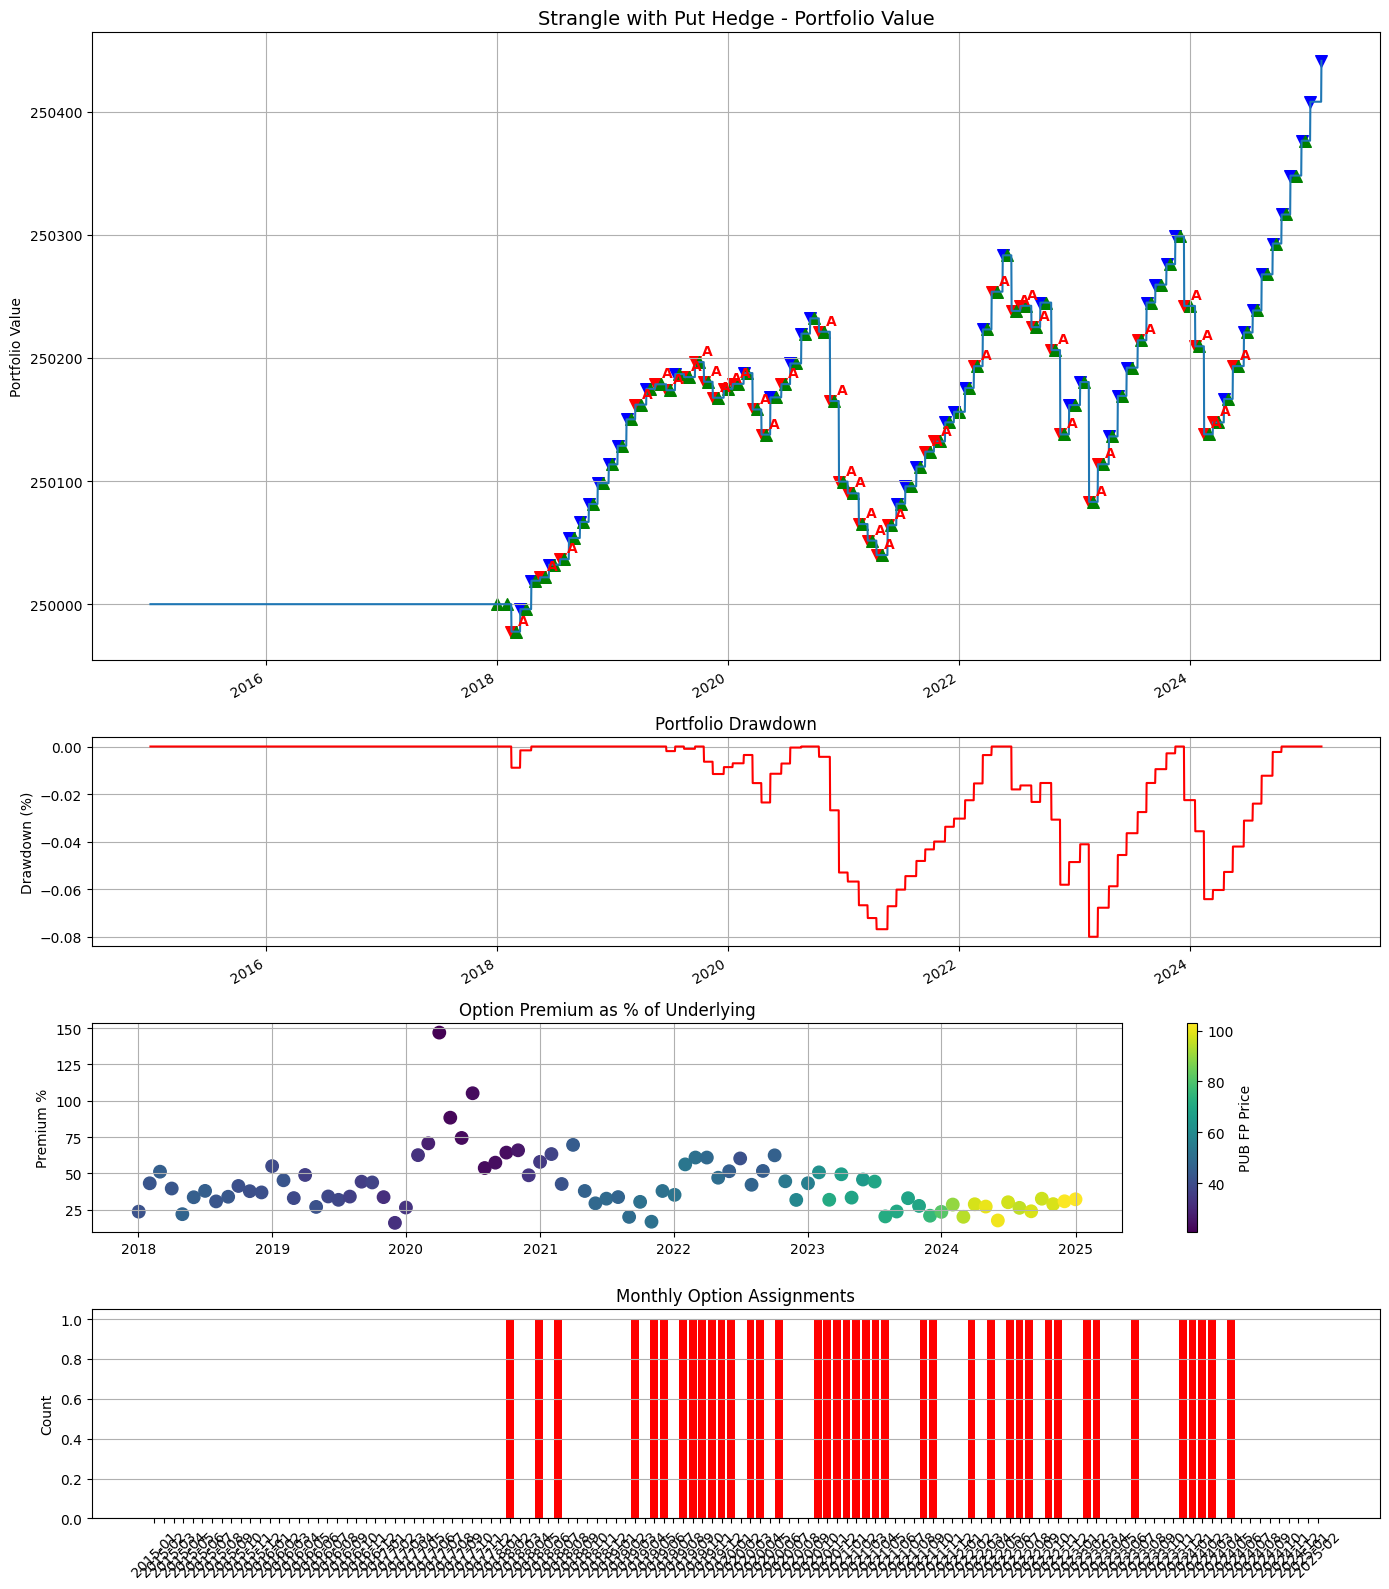


Strategy: Strangle with Put Hedge
Period: 2015-01-01 to 2025-02-25
Initial Capital: $250,000.00
Final Value: $250,441.12
Total Return: 0.18%
Sharpe Ratio: 0.64
Max Drawdown: -0.08%

Trade Statistics:
Total Trades: 85
Win Rate: 52.94%
Average Premium: $19.91
Average P&L per Trade: $4.24

Assignment Statistics:
Total Assignments: 40
Assignment Rate: 47.06%
Average Loss When Assigned: $-33.30
Maximum Loss When Assigned: $-125.89
Total Premium Collected: $1692.48
Profit/Premium Ratio: 0.21


(<classes.OptionStrategy.OptionStrategy at 0x26103fabe80>,
 2015-01-01    250000.000000
 2018-01-02    250000.000000
 2018-01-03    250000.000000
 2018-01-04    250000.000000
 2018-01-05    250000.000000
                   ...      
 2025-02-17    250407.948771
 2025-02-18    250407.948771
 2025-02-19    250407.948771
 2025-02-20    250407.948771
 2025-02-21    250441.124627
 Length: 1865, dtype: float64)

In [13]:
run_strangle_with_put_hedge(df, "PUB FP", start_date="2015-01-01", end_date="2025-02-25", otm_pct=0.05, hedge_pct=0.2, initial_capital=250000, position_sizing=10)


Running Straddle (ATM)...
  Net premium collected: $3338.18
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1000 Call(s) @ 68
  Short 1000 Put(s) @ 68
  Net premium collected: $4181.78
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1000 Call(s) @ 69
  Short 1000 Put(s) @ 69
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 68 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = -1163.10
Option K: 68 / Price at T: 66.8369 / PnL: 1.1631
  Position was assigned with P&L: $-1163.10
  Net premium collected: $4021.41
Entered strategy on 2018-03-01 00:00:00, expiry: 2018-04-20 00:00:00
  Short 1000 Call(s) @ 64
  Short 1000 Put(s) @ 64
Settled option Call position on 2018-03-16 00:00:00: Settlement = 0.00
Option K: 69 / Price at T: 66.0801 / PnL: 0
Settled option Put position on 2018-03-16 00:00:00: Settlement = -2919.90
Option K: 69 / Price at T: 66.0801 / PnL

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ha='center', va='center', fontsize=12)


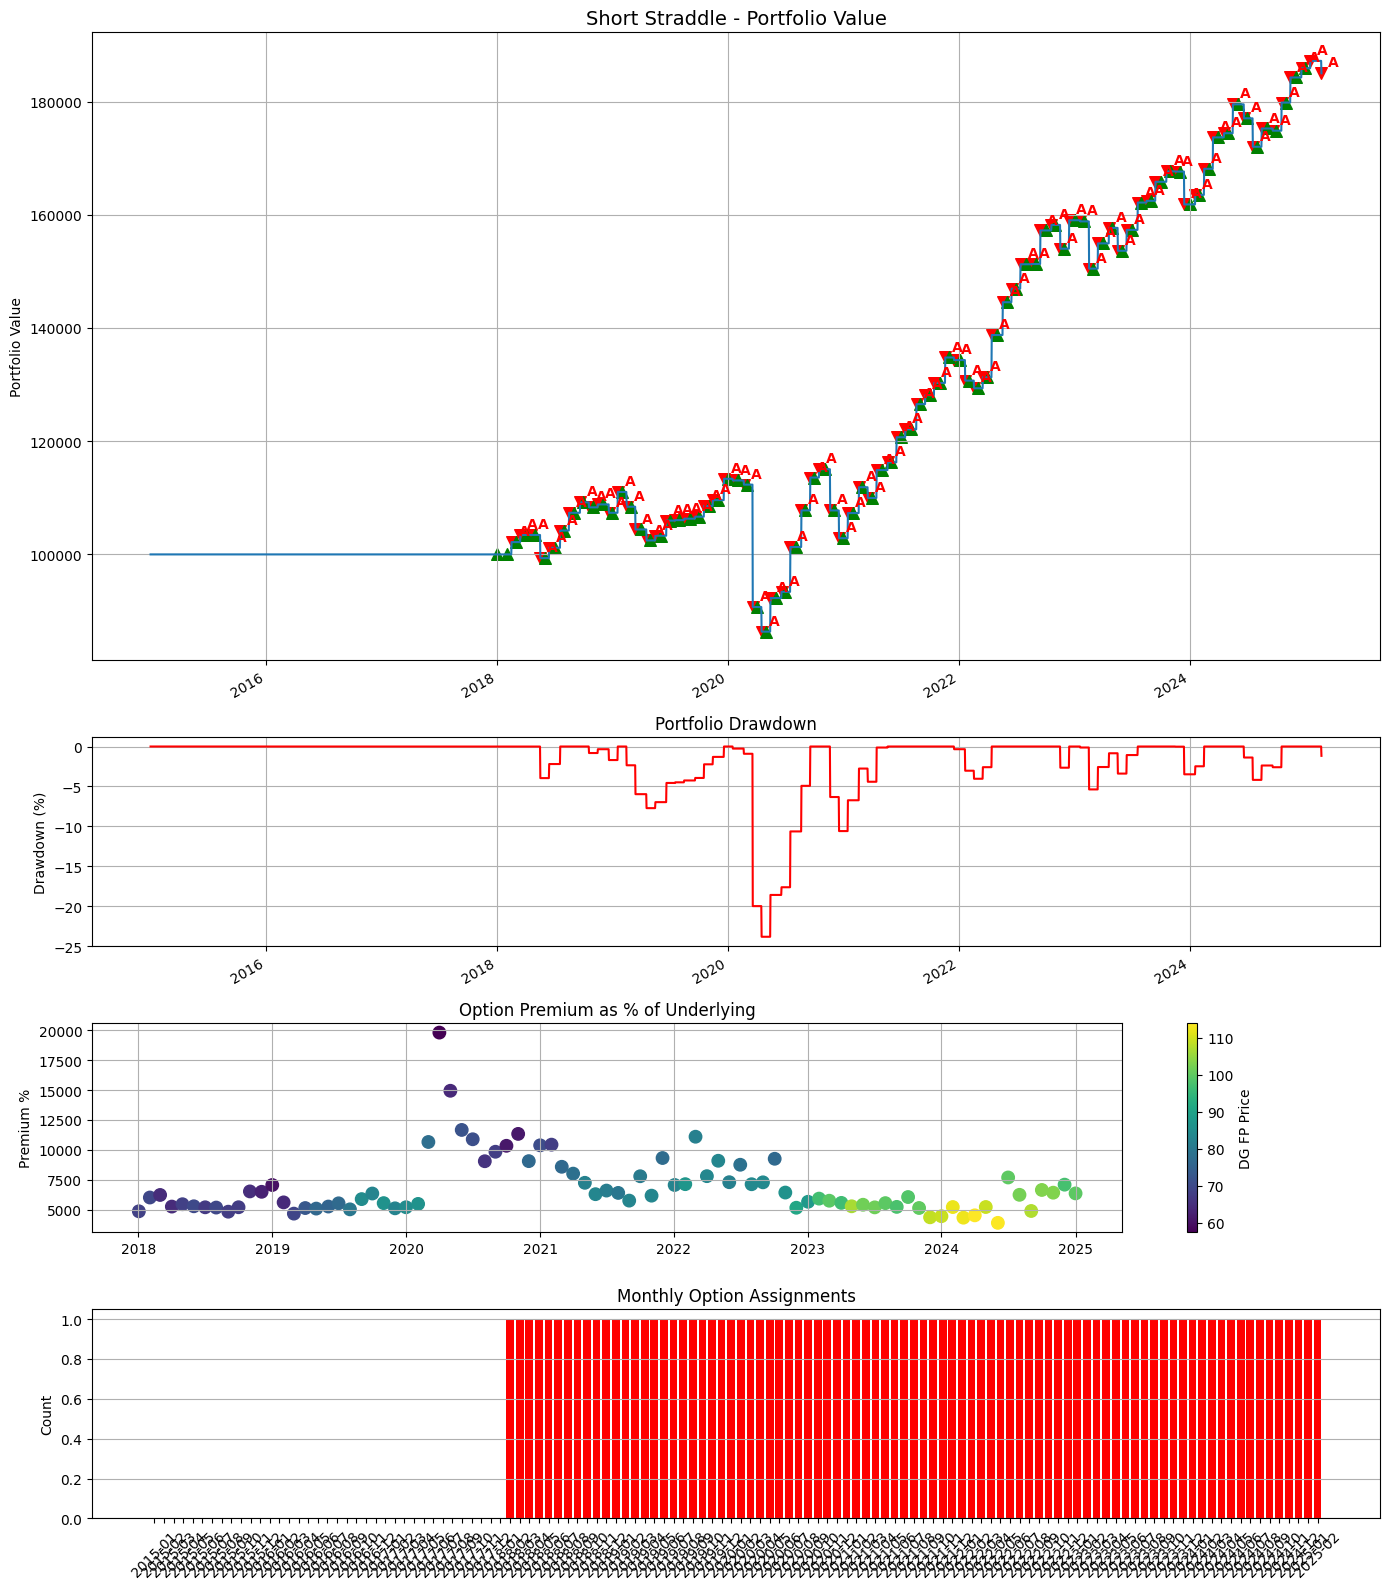


Strategy: Short Straddle
Period: 2015-01-01 to 2025-02-25
Initial Capital: $100,000.00
Final Value: $184,989.51
Total Return: 84.99%
Sharpe Ratio: 0.75
Max Drawdown: -23.82%

Trade Statistics:
Total Trades: 85
Win Rate: 0.00%
Average Premium: $5578.44
Average P&L per Trade: $999.88

Assignment Statistics:
Total Assignments: 85
Assignment Rate: 100.00%
Average Loss When Assigned: $-4578.56
Maximum Loss When Assigned: $-26342.20
Total Premium Collected: $474167.41
Profit/Premium Ratio: 0.18

Running Strangle (5% OTM)...
  Net premium collected: $926.49
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1000 Call(s) @ 72
  Short 1000 Put(s) @ 65
  Net premium collected: $1576.67
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1000 Call(s) @ 73
  Short 1000 Put(s) @ 66
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 72 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: S

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ha='center', va='center', fontsize=12)


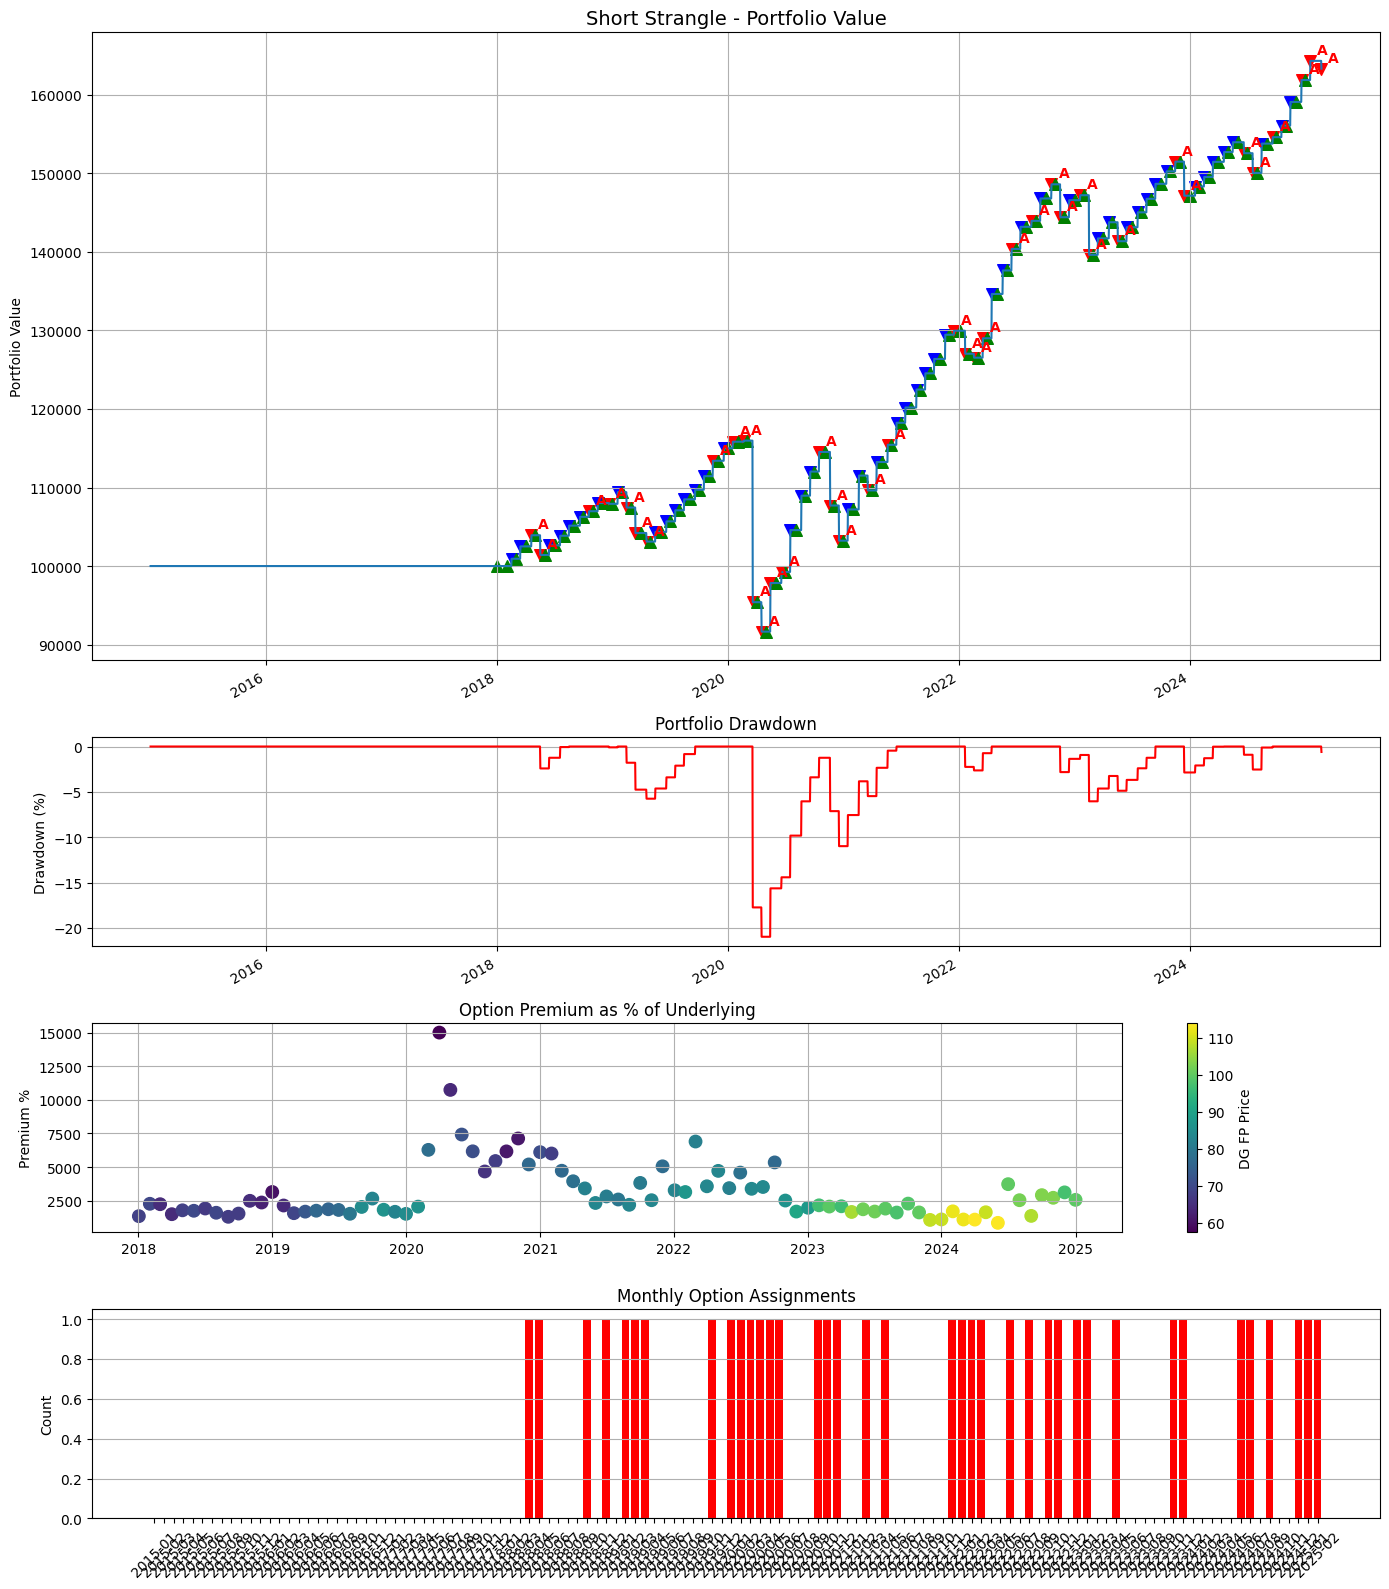


Strategy: Short Strangle
Period: 2015-01-01 to 2025-02-25
Initial Capital: $100,000.00
Final Value: $163,330.18
Total Return: 63.33%
Sharpe Ratio: 0.72
Max Drawdown: -20.97%

Trade Statistics:
Total Trades: 85
Win Rate: 55.29%
Average Premium: $2438.54
Average P&L per Trade: $745.06

Assignment Statistics:
Total Assignments: 38
Assignment Rate: 44.71%
Average Loss When Assigned: $-3788.06
Maximum Loss When Assigned: $-22342.20
Total Premium Collected: $207276.28
Profit/Premium Ratio: 0.31

Running Iron Condor...
  Net premium collected: $715.86
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1000 Call(s) @ 72
  Short 1000 Put(s) @ 65
  Long 1000 Call(s) @ 75
  Long 1000 Put(s) @ 62
  Net premium collected: $1126.34
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1000 Call(s) @ 73
  Short 1000 Put(s) @ 66
  Long 1000 Call(s) @ 76
  Long 1000 Put(s) @ 62
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Optio

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ha='center', va='center', fontsize=12)


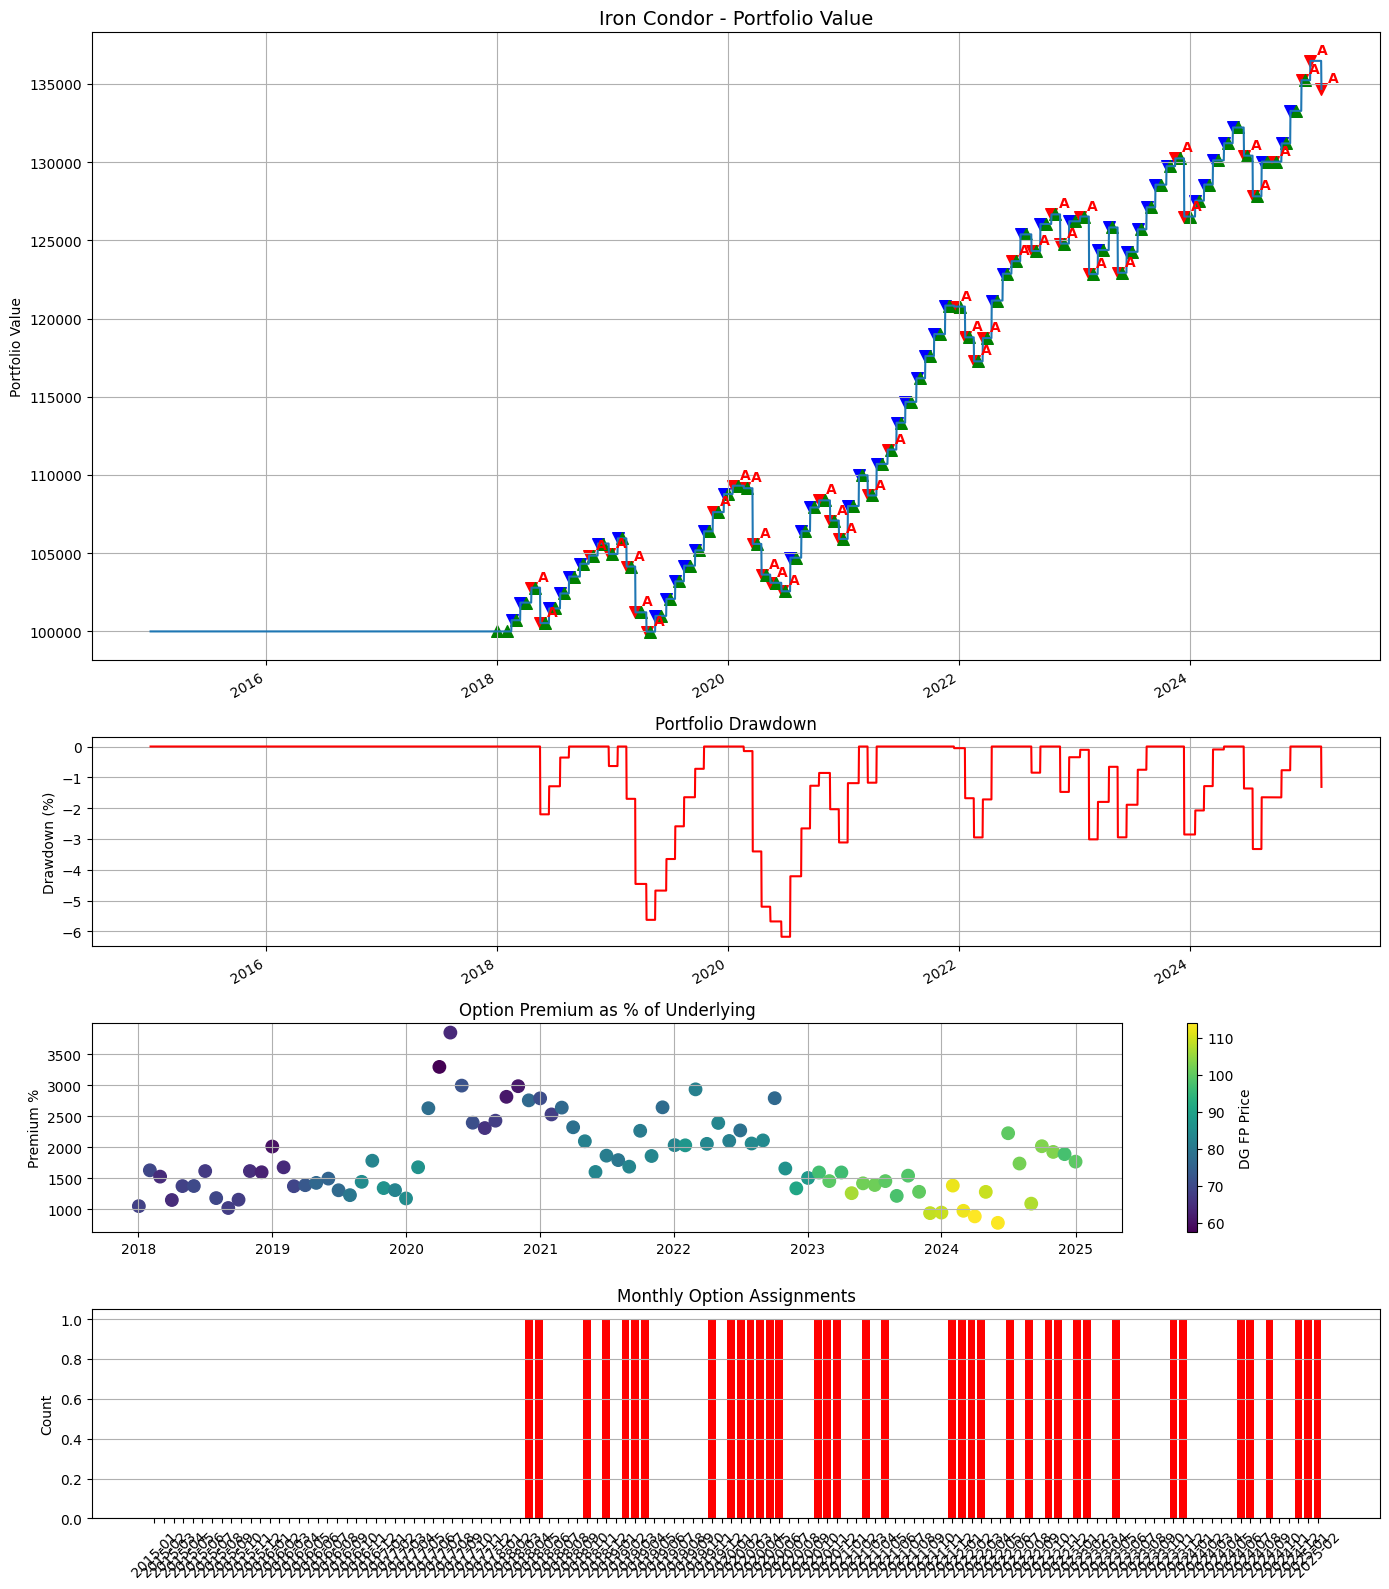


Strategy: Iron Condor
Period: 2015-01-01 to 2025-02-25
Initial Capital: $100,000.00
Final Value: $134,684.07
Total Return: 34.68%
Sharpe Ratio: 0.90
Max Drawdown: -6.18%

Trade Statistics:
Total Trades: 85
Win Rate: 55.29%
Average Premium: $1452.77
Average P&L per Trade: $-240.71

Assignment Statistics:
Total Assignments: 38
Assignment Rate: 44.71%
Average Loss When Assigned: $-3788.06
Maximum Loss When Assigned: $-22342.20
Total Premium Collected: $123485.87
Profit/Premium Ratio: -0.17

Running Strangle with Put Hedge...
  Net premium collected: $926.39
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1000 Call(s) @ 72
  Short 1000 Put(s) @ 65
  Long 1000 Put(s) @ 55
  Net premium collected: $1575.55
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1000 Call(s) @ 73
  Short 1000 Put(s) @ 66
  Long 1000 Put(s) @ 55
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 72 / Price at T: 66.8369 / PnL: 0
S

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ha='center', va='center', fontsize=12)


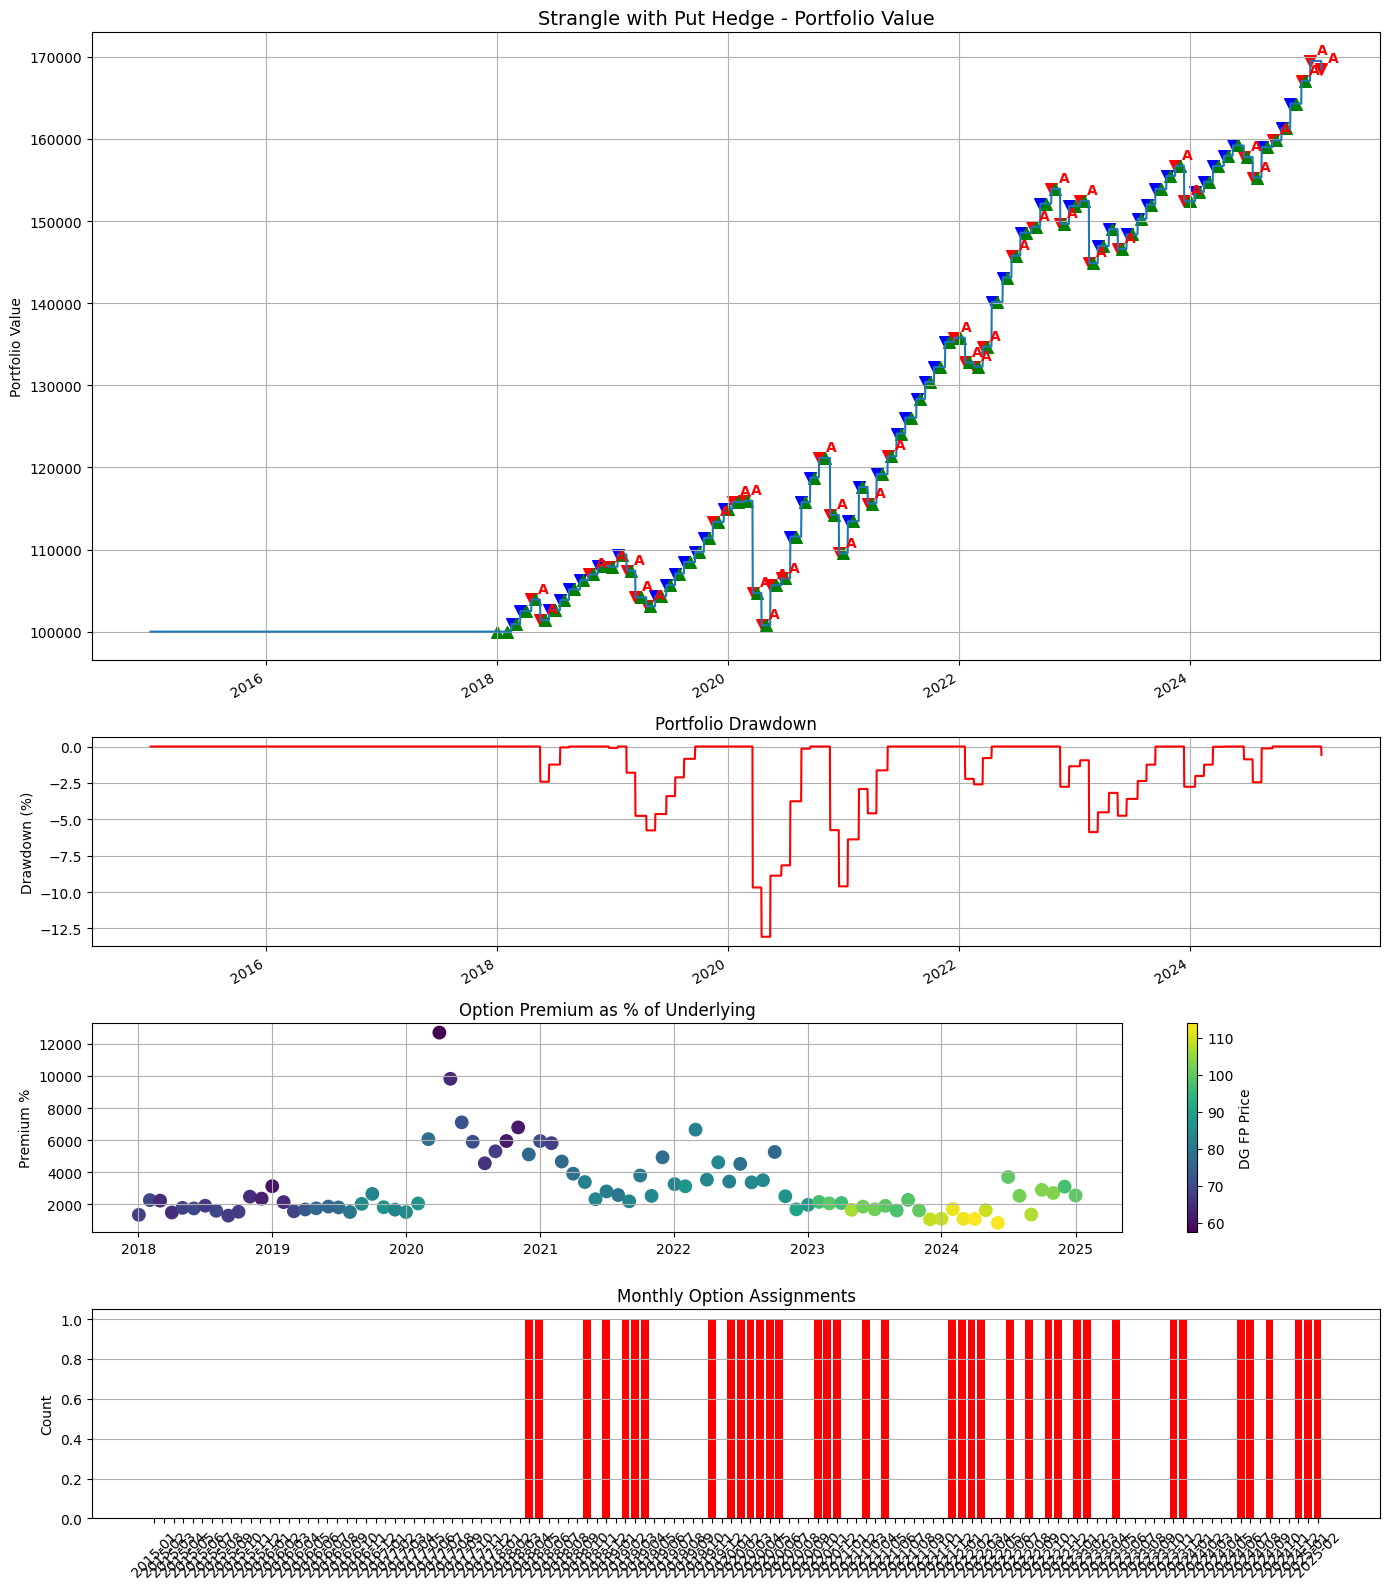


Strategy: Strangle with Put Hedge
Period: 2015-01-01 to 2025-02-25
Initial Capital: $100,000.00
Final Value: $168,509.12
Total Return: 68.51%
Sharpe Ratio: 0.93
Max Drawdown: -13.07%

Trade Statistics:
Total Trades: 85
Win Rate: 55.29%
Average Premium: $2389.56
Average P&L per Trade: $696.08

Assignment Statistics:
Total Assignments: 38
Assignment Rate: 44.71%
Average Loss When Assigned: $-3788.06
Maximum Loss When Assigned: $-22342.20
Total Premium Collected: $203113.02
Profit/Premium Ratio: 0.29

Running Straddle with Put Hedge...
  Net premium collected: $3338.07
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1000 Call(s) @ 68
  Short 1000 Put(s) @ 68
  Long 1000 Put(s) @ 55
  Net premium collected: $4180.66
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1000 Call(s) @ 69
  Short 1000 Put(s) @ 69
  Long 1000 Put(s) @ 55
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 68 / Price at T: 66.836

c:\Users\vince\OneDrive\Bureau\Programmation\Pergam\options\classes\OptionStrategy.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ha='center', va='center', fontsize=12)


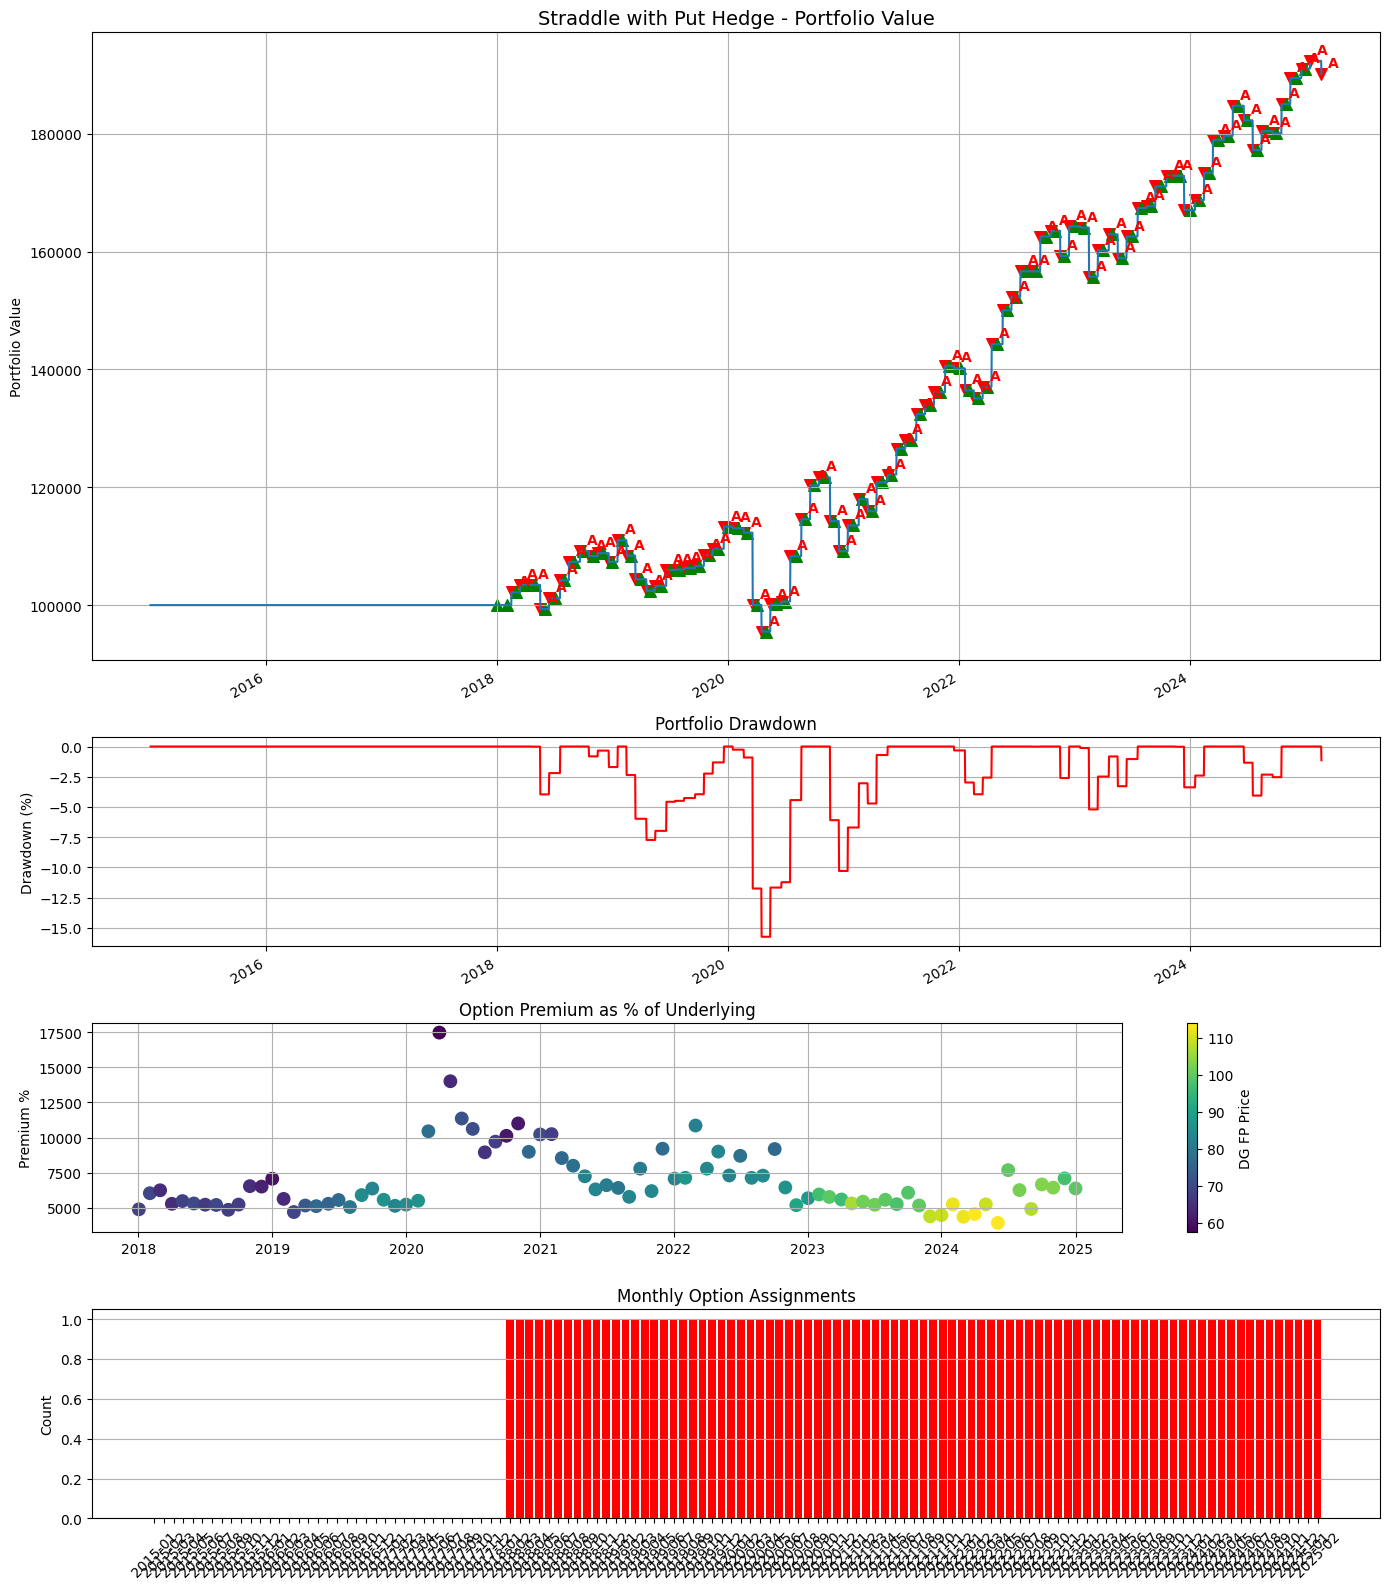


Strategy: Straddle with Put Hedge
Period: 2015-01-01 to 2025-02-25
Initial Capital: $100,000.00
Final Value: $190,168.45
Total Return: 90.17%
Sharpe Ratio: 0.91
Max Drawdown: -15.73%

Trade Statistics:
Total Trades: 85
Win Rate: 0.00%
Average Premium: $5529.46
Average P&L per Trade: $950.90

Assignment Statistics:
Total Assignments: 85
Assignment Rate: 100.00%
Average Loss When Assigned: $-4578.56
Maximum Loss When Assigned: $-26342.20
Total Premium Collected: $470004.15
Profit/Premium Ratio: 0.17


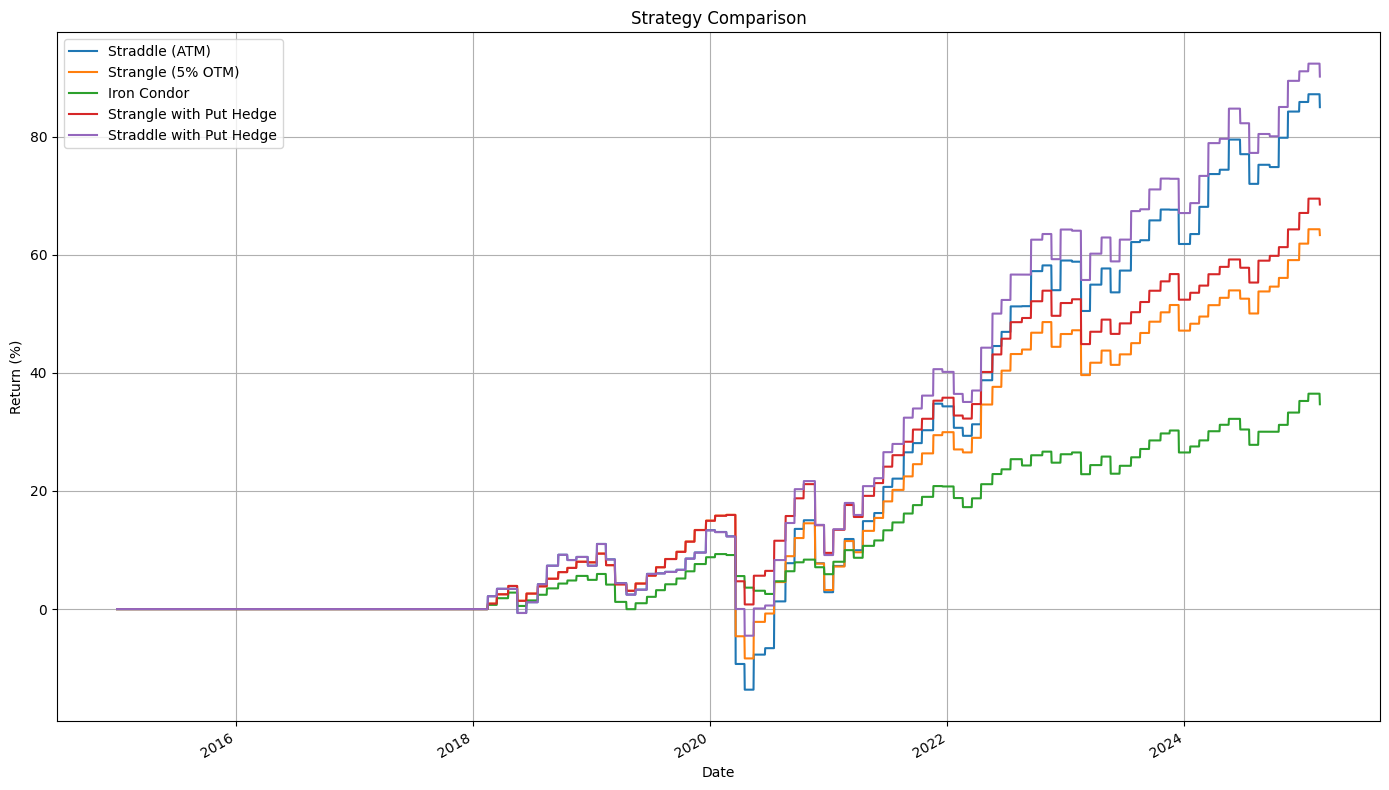


Strategy Performance Summary:
----------------------------------------------------------------------------------------------------
      Strategy       |   Return   |   Sharpe   |   Max DD   |  Win Rate  |  Assign %  |   Avg Premium  
----------------------------------------------------------------------------------------------------
   Straddle (ATM)    |   84.99   % |    0.75    |   -23.82  % |   0.00%    |  100.00%   | $   5578.44    
 Strangle (5% OTM)   |   63.33   % |    0.72    |   -20.97  % |   55.29%   |   44.71%   | $   2438.54    
    Iron Condor      |   34.68   % |    0.90    |   -6.18   % |   55.29%   |   44.71%   | $   1452.77    
Strangle with Put Hedge |   68.51   % |    0.93    |   -13.07  % |   55.29%   |   44.71%   | $   2389.56    
Straddle with Put Hedge |   90.17   % |    0.91    |   -15.73  % |   0.00%    |  100.00%   | $   5529.46    
----------------------------------------------------------------------------------------------------


({'Straddle (ATM)': 2015-01-01    100000.000000
  2018-01-02    100000.000000
  2018-01-03    100000.000000
  2018-01-04    100000.000000
  2018-01-05    100000.000000
                    ...      
  2025-02-17    187179.048935
  2025-02-18    187179.048935
  2025-02-19    187179.048935
  2025-02-20    187179.048935
  2025-02-21    184989.508587
  Length: 1865, dtype: float64,
  'Strangle (5% OTM)': 2015-01-01    100000.000000
  2018-01-02    100000.000000
  2018-01-03    100000.000000
  2018-01-04    100000.000000
  2018-01-05    100000.000000
                    ...      
  2025-02-17    164319.151998
  2025-02-18    164319.151998
  2025-02-19    164319.151998
  2025-02-20    164319.151998
  2025-02-21    163330.181464
  Length: 1865, dtype: float64,
  'Iron Condor': 2015-01-01    100000.000000
  2018-01-02    100000.000000
  2018-01-03    100000.000000
  2018-01-04    100000.000000
  2018-01-05    100000.000000
                    ...      
  2025-02-17    136474.260272
  2025-02-18

In [23]:
compare_strategies(df, "DG FP", start_date=pd.Timestamp("2015-01-01"), end_date=pd.Timestamp("2025-02-25"), position_sizing=1000)